# Exercício 3 - NLP

### Questão 1
Objetivo: prever se uma mensagem é spam ou não.

a) Qual porcentagem dos documentos são spam?

b) Usando mala de palavras (CountVectorizer), qual é o token mais longo do vocabulário dos dados de treinamento? Utilize o modelo de classificação multinomial Naive Bayes e encontre a (AUC) usando os dados de teste.

c) Utilize o vetorizador Tf-idf nos dados de treinamento. Quais 20 características têm o menor tf-idf e quais 20 têm o maior tf-idf? Coloque essas características em duas séries, onde cada série é classificada pelo valor tf-idf e, em seguida, em ordem alfabética pelo nome da característica. O índice da série deve ser o nome da característica e os dados devem ser o tf-idf. A série de 20 características com o menor tf-idfs deve ser classificada de forma crescente, a lista de 20 características com o maior tf-idfs deve ser classificada de forma decrescente. 

d) Utilize o vetorizador Tf-idf nos dados de treinamento, ignorando termos menor que 3. Use o modelo classificador multinomial Naive Bayes com alfa = 0.1, e então calcule a pontuação AUC usando os dados de teste. Avalie com diferentes valores para o parâmetro alfa e descreva brevemente como esse parâmetro se comporta no modelo.

e) Qual é o tamanho médio dos documentos (número de caracteres) para documentos não-spam e documentos spam? Utilize o vetorizador Tf-idf nos dados de treinamento, ignorando termos menor que 5. Usando essa matriz de termos de documento e um característica adicional (o comprimento do documento (número de caracteres)), treine um modelo SVC, e em seguida, calcule a AUC usando os dados de teste. Avalie com diferentes valores para o parâmetro de regularização C e descreva brevemente como esse parâmetro se comporta no modelo.

f) Qual é o número médio de dígitos por documento para documentos não-spam e documentos spam? Utilize o vetorizador Tf-idf nos dados de treinamento, ignorando termos menor que 5 e utilize unigramas, bigramas e trigramas. Usando essa matriz de termos de documento e duas características adicionais (o comprimento do documento e o número médio de dígitos por documento) treine um modelo de regressão logística, e em seguida, calcule a AUC usando os dados de teste. Avalie com diferentes valores para o parâmetro de regularização C e descreva brevemente como esse parâmetro se comporta no modelo.

g) Qual é o número médio de caracteres que não são palavras (tudo que não é uma letra, dígito ou underscore) por documento para documentos não-spam e documentos spam? Dica: use as classes de caracteres \w e \W do pacote re (regular expressions). Utilize o vetorizador CountVectorizer nos dados de treinamento, ignorando termos menor que 5 e utilize unigramas, bigramas e trigramas. Usando esta matriz de termos de documento e as seguintes características adicionais: o comprimento do documento, número de dígitos por documento, e o número de caracteres que não são palavras (tudo que não é uma letra, dígito ou underscore), treine um modelo de regressão logística, e em seguida, calcule a AUC usando os dados de teste. Avalie com diferentes valores para o parâmetro de regularização C e descreva brevemente como esse parâmetro se comporta no modelo. Encontre os 10 menores e os 10 maiores coeficientes do modelo e retorne-os juntamente com a pontuação da AUC em uma tupla. A lista dos 10 menores coeficientes deve ser classificada de forma crescente, a lista dos 10 maiores coeficientes de forma decrescente.

In [1]:
import numpy as np
import pandas as pd
import string
import re
import nltk
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve, roc_auc_score
import warnings
warnings.simplefilter("ignore")

In [2]:
df = pd.read_csv('spam.csv')

In [3]:
df.head(10)

,text,target
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham
5,FreeMsg Hey there darling it's been 3 week's n...,spam
6,Even my brother is not like to speak with me. ...,ham
7,As per your request 'Melle Melle (Oru Minnamin...,ham
8,WINNER!! As a valued network customer you have...,spam
9,Had your mobile 11 months or more? U R entitle...,spam


In [4]:
df['target'] = np.where(df['target']=='spam',1,0)
df.head()

,text,target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [5]:
# Criando uma cópia
temp_df = df.copy()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
text      5572 non-null object
target    5572 non-null int32
dtypes: int32(1), object(1)
memory usage: 65.4+ KB


# a)

In [7]:
neg, pos = np.bincount(df['target'])
total = neg + pos
print('Total: {}\n    Spam: {} ({:.2f}% do total)'.format(total, pos, 100 * pos / total))

Total: 5572
    Spam: 747 (13.41% do total)


Um dataset desbalanceado

# Vetorização do dataframe

# b)

In [8]:
# Dividindo o dataframe:

X_train, X_test, y_train, y_test = train_test_split(df['text'], 
                                                    df['target'], 
                                                    random_state=0)

In [9]:
# Count Vectorizer

count_vect = CountVectorizer()
X_train_vec = count_vect.fit_transform(X_train)
X_test_vec = count_vect.transform(X_test)

In [10]:
feature_names = count_vect.get_feature_names()

In [11]:
print('O token mais longo é: ' + sorted(feature_names, key=len)[-1])

O token mais longo é: com1win150ppmx3age16subscription


In [12]:
# Achando o melhor alpha

auc_scores=[]
for alpha in np.arange(0.01,1,0.01):
    model = MultinomialNB(alpha)
    model.fit(X_train_vec,  y_train)
    probs = model.predict_proba(X_test_vec)
    probs = probs[:, 1]
    auc_scores.append(roc_auc_score(y_test,probs))
auc_scores = np.array(auc_scores)
print('O melhor valor de alpha para o modelo: ', round(np.arange(0.01,5,0.01)[np.argmax(auc_scores)],3))
print('O valor do ROC AUC para o melhor alpha: ', max(auc_scores))

O melhor valor de alpha para o modelo:  0.2
O valor do ROC AUC para o melhor alpha:  0.991732169838548


Multinomial Naive Bayes: ROC AUC=0.991732


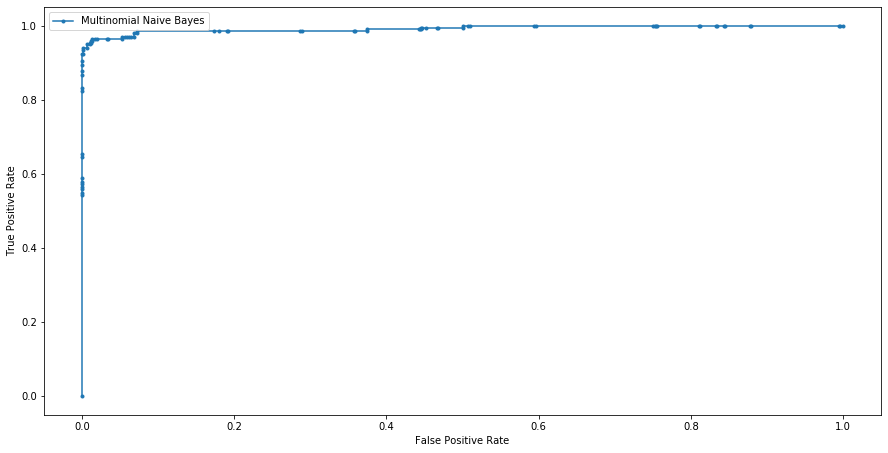

In [13]:
# Plot da curva ROC

model = MultinomialNB(alpha=0.2)
model.fit(X_train_vec,  y_train)
probs = model.predict_proba(X_test_vec)
probs = probs[:, 1]
auc = roc_auc_score(y_test,probs)
print('Multinomial Naive Bayes: ROC AUC=%.6f' % (auc))
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=[15,7.5])
plt.plot(fpr, tpr, marker='.', label='Multinomial Naive Bayes')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Usando TF-IDF

# c)

In [14]:
# TF-IDF Vectorizer

tfidf_vect = TfidfVectorizer()
X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)

In [15]:
feature_names = tfidf_vect.get_feature_names()

In [16]:
# Obtendo um dicionário contendo as palavras e o valor TD-IDF:

palavras_tfidf={}
for doc in range(0, X_train_tfidf.shape[0]):
    feature_index = X_train_tfidf[doc,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [X_train_tfidf[doc, x] for x in feature_index])
    for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
        palavras_tfidf[w]=s
palavras_tfidf = sorted(palavras_tfidf.items(), key=lambda x: x[1])

In [17]:
palavras_tfidf_sort={}
for i in range(0, len(palavras_tfidf)):
          palavras_tfidf_sort[palavras_tfidf[i][0]]=palavras_tfidf[i][1]  

In [18]:
menores = {}
for keys, i in zip(list(palavras_tfidf_sort.keys()), range(0,20)):
    menores[keys] = palavras_tfidf_sort[keys]

In [19]:
maiores={}
keys = [list(palavras_tfidf_sort.keys())[i] for i in range(-21, 0)]
for key, i in zip(keys, range(0,20)):
    maiores[key] = palavras_tfidf_sort[key]

In [20]:
serie_menores=pd.Series(menores)
serie_menores.sort_index(ascending=True, inplace=True)
serie_menores

aaniye          0.074475
athletic        0.074475
boyfriend       0.070982
chef            0.074475
courageous      0.074475
dependable      0.074475
determined      0.074475
exterminator    0.074475
healer          0.074475
intelligent     0.068503
listener        0.074475
organizer       0.074475
pest            0.074475
problem         0.068719
psychiatrist    0.074475
psychologist    0.074475
pudunga         0.074475
stylist         0.074475
sympathetic     0.074475
venaam          0.074475
dtype: float64

In [21]:
serie_maiores=pd.Series(maiores)
serie_maiores.sort_index(ascending=False,inplace=True)
serie_maiores

wrkin           0.829797
tick            0.980166
thanx           1.000000
thanks2         0.859835
stalking        0.802985
significance    0.875113
romantic        0.840358
okie            1.000000
ok              1.000000
nervous         0.828181
fetch           0.865126
er              1.000000
ello            0.796417
dependents      0.798033
continent       0.874661
comingdown      0.807953
bloo            0.908409
blank           0.932702
beerage         1.000000
146tf150p       1.000000
dtype: float64

# d)

In [22]:
tfidf_vect = TfidfVectorizer(min_df=3)
X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)

Multinomial Naive Bayes com alpha 0.1: ROC AUC = 0.9954968337775665


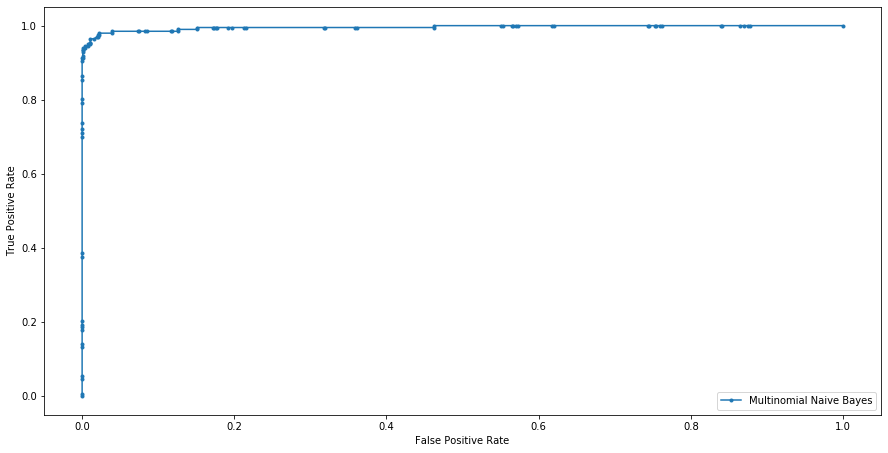

In [23]:
# Plot da curva ROC
plt.figure(figsize=[15,7.5])
alpha = 0.1
model = MultinomialNB(alpha)
model.fit(X_train_tfidf,  y_train)
probs = model.predict_proba(X_test_tfidf)
probs = probs[:, 1]
auc = roc_auc_score(y_test,probs)
print('Multinomial Naive Bayes com alpha {}: ROC AUC = {}'.format(alpha, auc))
fpr, tpr, _ = roc_curve(y_test, probs)
plt.plot(fpr, tpr, marker='.', label='Multinomial Naive Bayes')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [24]:
auc_scores=[]
for alpha in np.arange(0.01,1,0.01):
    model = MultinomialNB(alpha)
    model.fit(X_train_tfidf,  y_train)
    probs = model.predict_proba(X_test_tfidf)
    probs = probs[:, 1]
    auc_scores.append(roc_auc_score(y_test,probs))
auc_scores = np.array(auc_scores)
print('O melhor valor de alpha para o modelo: ', round(np.arange(0.01,5,0.01)[np.argmax(auc_scores)],3))
print('O valor do ROC AUC para o melhor alpha: ', max(auc_scores))

O melhor valor de alpha para o modelo:  0.08
O valor do ROC AUC para o melhor alpha:  0.9955392764375329


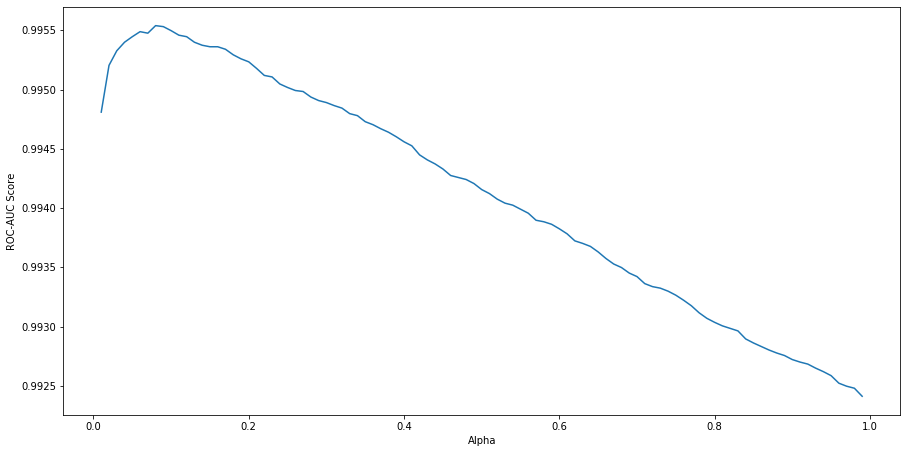

In [25]:
# Plot de ROC AUC X Alpha

plt.figure(figsize=[15,7.5])
plt.plot(np.arange(0.01,1,0.01), auc_scores)
plt.xlabel('Alpha')
plt.ylabel('ROC-AUC Score')
plt.show()

# e)

In [26]:
# Encontrando o tamanho médio dos e-mails:
temp_df['len'] = temp_df['text'].str.len()
mean_length = temp_df.groupby('target')['len'].agg('mean').values

In [27]:
print('O valor médio do tamanho dos documentos nos e-mails spam  é: {}'.format(int(round((mean_length[1]), 0))))
print('O valor médio do tamanho dos documentos nos e-mails não spam  é: {}'.format(int(round((mean_length[0]), 0))))

O valor médio do tamanho dos documentos nos e-mails spam  é: 139
O valor médio do tamanho dos documentos nos e-mails não spam  é: 71


In [28]:
# Adicionar característica para sparse matrix:

def new_carac(X, carac):
    return hstack([X, csr_matrix(carac).T], 'csr')

In [29]:
X_train, X_test, y_train, y_test = train_test_split(temp_df.drop('target', axis=1), temp_df['target'] , random_state=0)

In [30]:
tfidf_vect = TfidfVectorizer(min_df=5)
X_train_tfidf = tfidf_vect.fit_transform(X_train['text'])
X_test_tfidf = tfidf_vect.transform(X_test['text'])
X_train_tfidf = new_carac(X_train_tfidf, X_train['len'])
X_test_tfidf = new_carac(X_test_tfidf, X_test['len'])

In [31]:
# Treinando o modelo com o parametro C=1 (default):

model = SVC()
model.fit(X_train_tfidf,  y_train)
y_score = model.decision_function(X_test_tfidf)
roc_auc_score(y_test, y_score)

0.806020066889632

Um resultado muito ruim. Vamos tentar melhorar a métrica mudando o valor de C

In [32]:
auc_scores=[]
for n in np.arange(1, 1000 , 50):
    model = SVC(C=n)
    model.fit(X_train_tfidf,  y_train)
    y_score = model.decision_function(X_test_tfidf)
    auc_scores.append(roc_auc_score(y_test, y_score))
print('O melhor valor de C para o modelo: ', round(np.arange(1, 1000, 50)[np.argmax(auc_scores)],3))
print('O valor do ROC AUC para o melhor C: ', max(auc_scores))

O melhor valor de C para o modelo:  951
O valor do ROC AUC para o melhor C:  0.9957514897373648


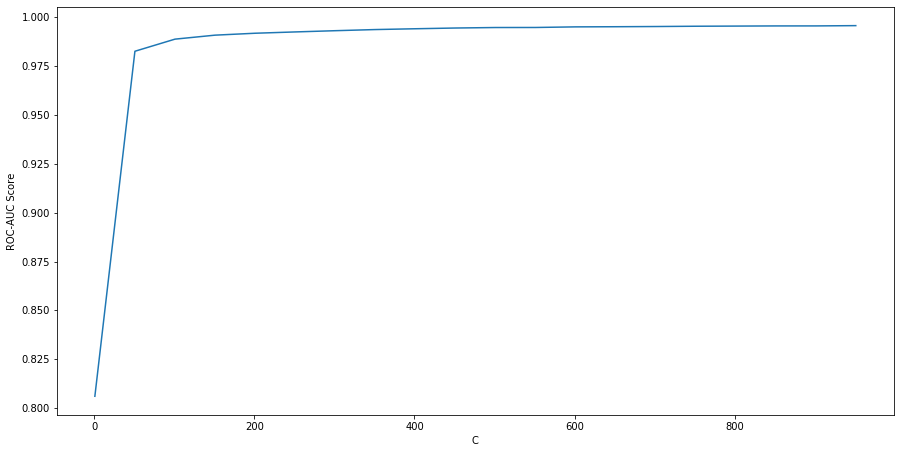

In [33]:
# Plot de ROC-AUC x C
plt.figure(figsize=[15,7.5])
plt.plot(np.arange(1, 1000 , 50), auc_scores)
plt.xlabel('C')
plt.ylabel('ROC-AUC Score')
plt.show()

Podemos notar que encontrar o melhor de C não é tão simples quanto encontrar o valor de alpha, uma vez que o fit do algoritmo SVC demora muito mais do que o MultinomialNB. No entanto, é possível encontrar um valor mais alto da métrica ROC-AUC do que o modelo anterior para um C mais elevado.

# f)

In [34]:
temp_df['digits_count'] = temp_df['text'].apply(lambda row: len(re.findall(r'(\d)', row)))
average_digits = temp_df.groupby('target')['digits_count'].agg('mean').values
print('O valor médio do número de caracteres nos e-mails spam  é: {}'.format((round((average_digits[1]), 3))))
print('O valor médio do número de caracteres nos e-mails não spam  é: {}'.format(round((average_digits[0]), 3)))

O valor médio do número de caracteres nos e-mails spam  é: 15.759
O valor médio do número de caracteres nos e-mails não spam  é: 0.299


In [35]:
X_train, X_test, y_train, y_test = train_test_split(temp_df.drop('target', axis=1), temp_df['target'], random_state=0)

In [36]:
tfidf_vect = TfidfVectorizer(min_df=5, ngram_range=(1, 3))
X_train_tfidf = tfidf_vect.fit_transform(X_train['text'])
X_test_tfidf = tfidf_vect.transform(X_test['text'])
X_train_tfidf = new_carac(X_train_tfidf, X_train['len'])
X_test_tfidf = new_carac(X_test_tfidf, X_test['len'])
X_train_tfidf = new_carac(X_train_tfidf, X_train['digits_count'])
X_test_tfidf = new_carac(X_test_tfidf, X_test['digits_count'])

In [37]:
# Treinando o modelo com o parametro C=1 (default):

model = LogisticRegression()
model.fit(X_train_tfidf,  y_train)
y_score = model.decision_function(X_test_tfidf)
roc_auc_score(y_test, y_score)

0.9960740539531093

Um excelente valor, vamos tentar melhorar um pouco mais.

In [38]:
auc_scores=[]
for n in np.arange(1, 20 , 0.05):
    model = LogisticRegression(C=n)
    model.fit(X_train_tfidf,  y_train)
    y_score = model.decision_function(X_test_tfidf)
    auc_scores.append(roc_auc_score(y_test, y_score))
print('O melhor valor de C para o modelo: ', round(np.arange(1, 20, 0.05)[np.argmax(auc_scores)],3))
print('O valor do ROC AUC para o melhor C: ', max(auc_scores))

O melhor valor de C para o modelo:  10.85
O valor do ROC AUC para o melhor C:  0.9974407076040269


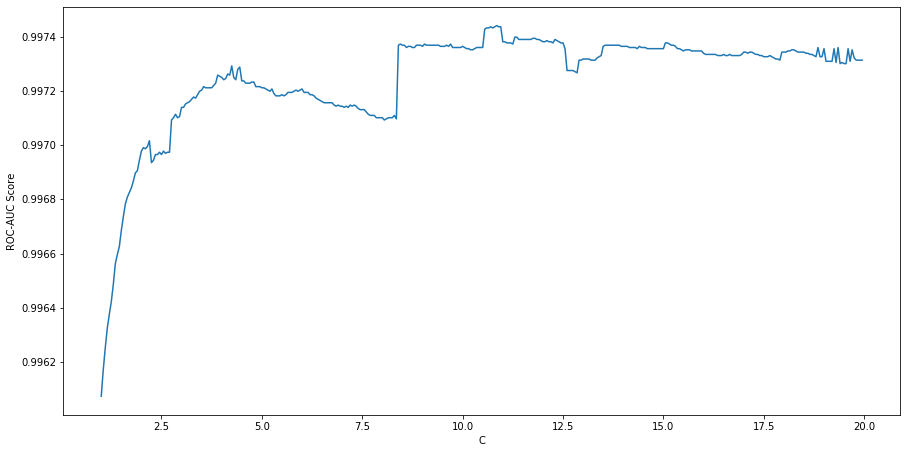

In [39]:
# Plot de ROC-AUC x C
plt.figure(figsize=[15,7.5])
plt.plot(np.arange(1, 20 , 0.05), auc_scores)
plt.xlabel('C')
plt.ylabel('ROC-AUC Score')
plt.show()

# g)

In [40]:
temp_df['non_word'] = temp_df['text'].apply(lambda row: len(re.findall(r'\W', row)))
average_nonword = temp_df.groupby('target')['non_word'].agg('mean').values
print('O valor médio de caracteres que não são palavras nos e-mails spam é: {}'.format((round((average_nonword[1]), 3))))
print('O valor médio de caracteres que não são palavras nos e-mails não spam é: {}'.format(round((average_nonword[0]), 3)))

O valor médio de caracteres que não são palavras nos e-mails spam é: 29.041
O valor médio de caracteres que não são palavras nos e-mails não spam é: 17.292


In [41]:
X_train, X_test, y_train, y_test = train_test_split(temp_df.drop('target', axis=1), temp_df['target'], random_state=0)

In [42]:
count_vect = CountVectorizer(min_df=5, ngram_range=(1, 3))
X_train_vec = count_vect.fit_transform(X_train['text'])
X_test_vec = count_vect.transform(X_test['text'])
X_train_vec = new_carac(X_train_vec, X_train['len'])
X_test_vec = new_carac(X_test_vec, X_test['len'])
X_train_vec = new_carac(X_train_vec, X_train['digits_count'])
X_test_vec = new_carac(X_test_vec, X_test['digits_count'])
X_train_vec = new_carac(X_train_vec, X_train['non_word'])
X_test_vec = new_carac(X_test_vec, X_test['non_word'])

In [43]:
auc_scores=[]
for n in np.arange(1, 20 , 0.05):
    model = LogisticRegression(C=n)
    model.fit(X_train_vec,  y_train)
    y_score = model.decision_function(X_test_vec)
    auc_scores.append(roc_auc_score(y_test, y_score))
print('O melhor valor de C para o modelo: ', round(np.arange(1, 20, 0.05)[np.argmax(auc_scores)],3))
print('O valor do ROC AUC para o melhor C: ', max(auc_scores))

O melhor valor de C para o modelo:  1.15
O valor do ROC AUC para o melhor C:  0.997839668607711


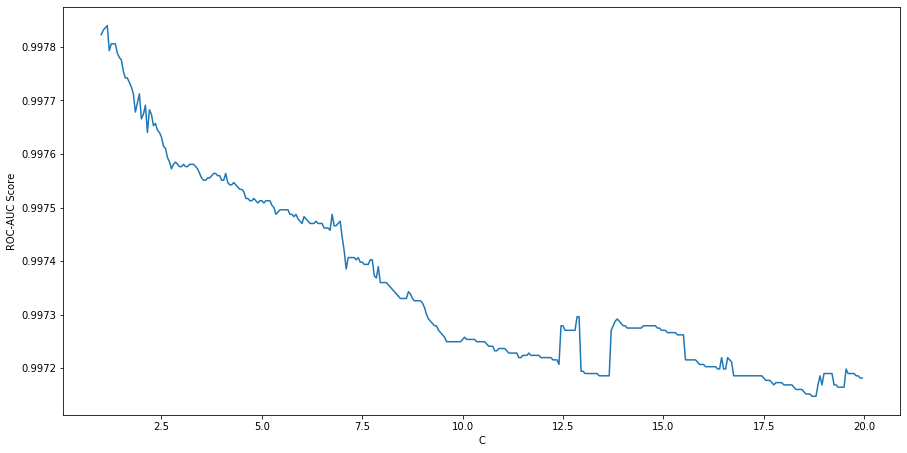

In [44]:
# Plot de ROC-AUC x C
plt.figure(figsize=[15,7.5])
plt.plot(np.arange(1,20 , 0.05), auc_scores)
plt.xlabel('C')
plt.ylabel('ROC-AUC Score')
plt.show()

Pode-se perceber que o ROC AUC para esse caso se comporta de forma bastante diferente do anterior.

In [45]:
feature_names = count_vect.get_feature_names()
feature_names = np.array(count_vect.get_feature_names())

In [46]:
model = LogisticRegression(C=1.15)
model.fit(X_train_vec,  y_train)

LogisticRegression(C=1.15, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [47]:
sorted_coef_index = model.coef_[0].argsort()
largest = feature_names[sorted_coef_index[:-11:-1]]
smallest = feature_names[sorted_coef_index[:10]]

In [48]:
score = 0.997839668607711

In [49]:
tupla = (score,[sorted(largest, key = len, reverse=True), sorted(smallest, key = len, reverse=False)])

In [50]:
tupla

(0.997839668607711,
 [['ringtone',
   'content',
   'tones',
   'reply',
   'order',
   'text',
   'free',
   'sale',
   'sms',
   'uk'],
  ['my', 'ì_', 'if', 'ah', 'got', 'say', 'wan', '1st', 'pls', 'tomorrow']])